In [66]:
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from xgboost import XGBClassifier  
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('data/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Some data analysis

In [3]:
print("n rows:", df.shape[0])
for col in df.columns.drop(['PassengerId', 'CryoSleep', 'VIP', 'Transported']):
    print(col, df[col].nunique())

n rows: 8693
HomePlanet 3
Cabin 6560
Destination 3
Age 80
RoomService 1273
FoodCourt 1507
ShoppingMall 1115
Spa 1327
VRDeck 1306
Name 8473


In [4]:
cat_cols = df.select_dtypes(include='object').columns.to_list()
num_cols = df.select_dtypes(include='float64').columns.to_list()
assert len(cat_cols) + len(num_cols) == df.shape[1] - 1 # make sure we didn't miss any columns
num_cols

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

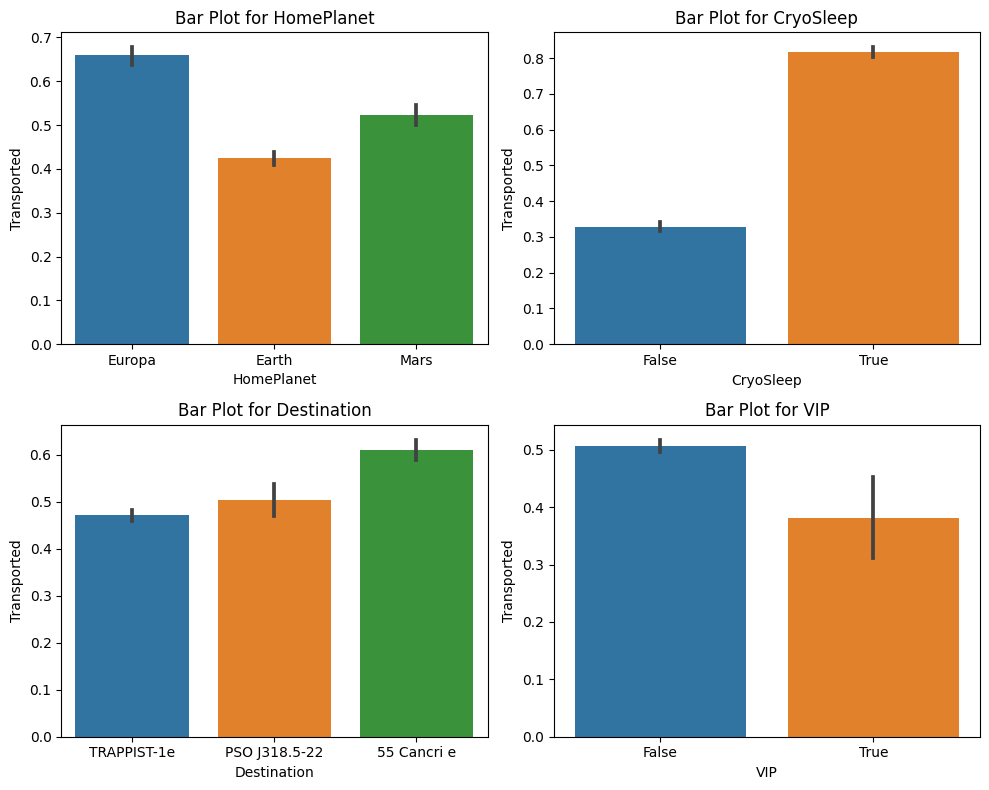

In [5]:
cat_to_plot = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# Flatten the axes array for easier iteration
axes = axes.flatten()
for i, cat in enumerate(cat_to_plot):
    sns.barplot(x=cat, y='Transported', data=df, ax=axes[i])
    axes[i].set_title(f'Bar Plot for {cat}')
plt.tight_layout()
# Show the plots
plt.show()


we see that CryoSleep might be a really important feature to keep, the others seems less informative.

Now let's analyse some numerical features:

In [46]:
df_increases = df.copy()
df_increases['total_expenses'] = df_increases[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

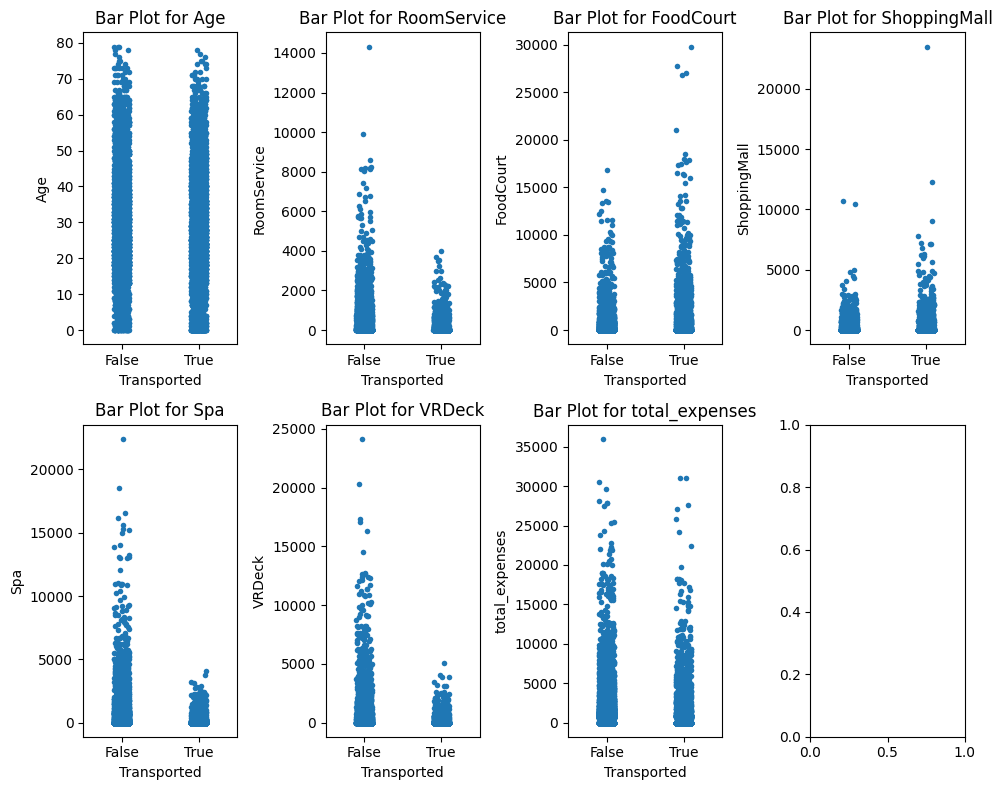

In [47]:
fig, axes = plt.subplots(2, 4, figsize=(10, 8))
# Flatten the axes array for easier iteration
axes = axes.flatten()
for i, cat in enumerate(num_cols + ['total_expenses']):
    #sns.swarmplot(y=cat, x='Transported', data=df.head(100), ax=axes[i])
    sns.stripplot(y=cat, x='Transported', data=df_increases, ax=axes[i], jitter=True, size=4)
    axes[i].set_title(f'Bar Plot for {cat}')
plt.tight_layout()
# Show the plots
plt.show()

we see that Age, ShoppingMall don't seem to matter, so we don't keep them.

We can now analyse the passengerId and cabin influence

In [48]:
# create three new column based on the splitting of cabin column on the / character
df_increases['Deck'] = df['Cabin'].str.split('/').str[0]
df_increases['Num'] = df['Cabin'].str.split('/').str[1]
df_increases['Side'] = df['Cabin'].str.split('/').str[2]
df_increases['Passenger_Group'] = df['PassengerId'].str.split('_').str[0].apply(int)
df_increases['Passenger_Number'] = df['PassengerId'].str.split('_').str[1].apply(int)
df_increases.drop(columns='Cabin', inplace=True)

In [52]:
df_increases[['Deck', 'Num', 'Side', 'Passenger_Group', 'Passenger_Number']].head()
df_increases['Passenger_Group'].nunique(), df_increases['Passenger_Number'].nunique(), 

(6217, 8)

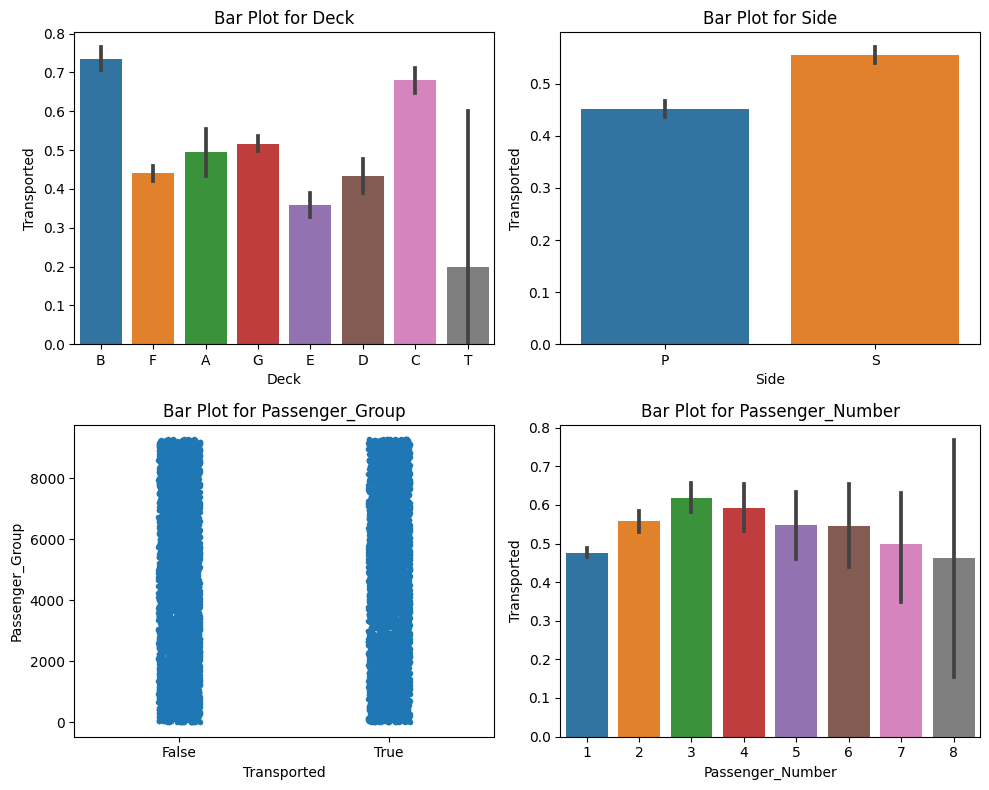

In [53]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
for i, cat in enumerate(['Deck', 'Side', 'Passenger_Group', 'Passenger_Number']):
    if cat == 'Passenger_Group':
        sns.stripplot(y=cat, x='Transported', data=df_increases, ax=axes[i], jitter=True, size=4)
    else:
        sns.barplot(x=cat, y='Transported', data=df_increases, ax=axes[i])
    axes[i].set_title(f'Bar Plot for {cat}')
plt.tight_layout()
plt.show()

As we see Deck and Side might be interesting features to keep. However Passenger Number and Passenger Group don't seems to bring any pertinent information so we don't keep them.

In [79]:
cols_to_remove = ['Age', 'ShoppingMall', 'Passenger_Group', 'Passenger_Number', 'Num', 'total_expenses']
df_decreases = df_increases.drop(columns=cols_to_remove + ['PassengerId'])
y = df_decreases.pop('Transported')
df_decreases.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,Spa,VRDeck,Name,Deck,Side
0,Europa,False,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,Maham Ofracculy,B,P
1,Earth,False,TRAPPIST-1e,False,109.0,9.0,549.0,44.0,Juanna Vines,F,S
2,Europa,False,TRAPPIST-1e,True,43.0,3576.0,6715.0,49.0,Altark Susent,A,S
3,Europa,False,TRAPPIST-1e,False,0.0,1283.0,3329.0,193.0,Solam Susent,A,S
4,Earth,False,TRAPPIST-1e,False,303.0,70.0,565.0,2.0,Willy Santantines,F,S


We can now replace missing values and standardize/encode

In [80]:
num_cols = df_decreases.select_dtypes(include='float64').columns.to_list()
cat_cols = df_decreases.select_dtypes(include='object').columns.to_list()
assert len(num_cols) + len(cat_cols) == df_decreases.shape[1]

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  
])

# Bundle transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

In [81]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train, X_val, y_train, y_val = train_test_split(df_decreases, y_encoded, test_size=0.2, random_state=42)

In [95]:
model = XGBClassifier(n_estimators=100, random_state=0, objective='binary:logistic')

# Create and evaluate the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

# Train the model on the training set
clf.fit(X_train, y_train)

# Evaluate the model on the validation set
accuracy = clf.score(X_val, y_val)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

Validation Accuracy: 78.15%


In [91]:
X_test = pd.read_csv('data/test.csv')
passengerId = X_test['PassengerId']
X_test['Deck'] = X_test['Cabin'].str.split('/').str[0]
X_test['Side'] = X_test['Cabin'].str.split('/').str[2]
cols_to_remove = ['Age', 'ShoppingMall', 'PassengerId', 'Cabin']
X_test = X_test.drop(columns=cols_to_remove)
y_pred = clf.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred)
result = pd.DataFrame({'PassengerId': passengerId, 'Transported': y_pred})
result.to_csv('data/result_without_model_tuning.csv', index=False)


Experiment to do:
Split name into first/last and see if it has an influence on the transportation